In [74]:
import warnings
warnings.filterwarnings(action='ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [133]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np
import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from PIL import Image
import cv2
%matplotlib inline

In [76]:
dataset_paths = glob.glob("archive/**/**/*.jpg")

1022
[688 480 907 109 289 990 132  70 229  70 278 749]


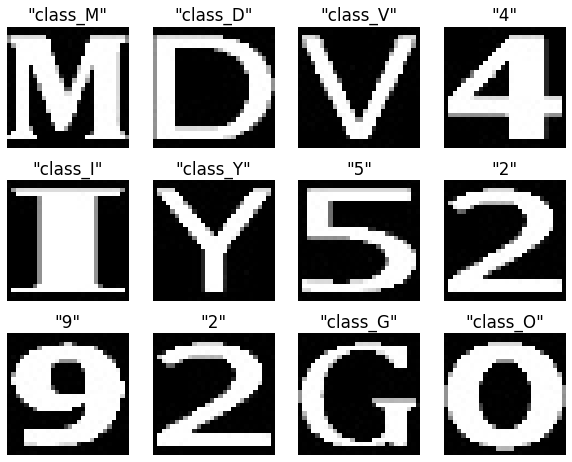

In [132]:
cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(50)
print(len(dataset_paths))
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))
print(rand)
# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)
 

In [78]:
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)

[INFO] Find 1022 images with 37 classes


In [79]:
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.20, stratify=y, random_state=50)


In [94]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    'archive/Training Data/',
    target_size=(42, 42),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

Found 24530 images belonging to 36 classes.


In [95]:
validation_generator = train_datagen.flow_from_directory(
    'archive/Training Data/',
    target_size=(42, 42),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 6104 images belonging to 36 classes.


In [82]:
model = keras.Sequential([
        
        # Add first Convolutional Layer
        layers.Conv2D(filters=32, kernel_size=3, activation='relu',
                      padding='same', input_shape=(42,42,3)),
        # Add a second Convolutional Layer
        layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
        # Add a Max pooling layer
        layers.MaxPool2D(pool_size=(2, 2)),
        # Add a Dropout layer
        layers.Dropout(0.25),
    
        layers.BatchNormalization(),
        # Add third Convolutional Layer
        layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding = 'same'),
        # Add Fourth Convolutional Layer
        layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
        # Add a Max pooling layer
        layers.MaxPool2D(pool_size=(2, 2)),
        # Add a Dropout Layer
        layers.Dropout(0.25),

        layers.BatchNormalization(),
        # Add Fifth Convolutional Layer
        layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding = 'same'),
        # Add a sixth Convolutional Layer
        layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
        # Add a Max Pooling Layer
        layers.MaxPool2D(pool_size=(2, 2)),
        # Add a Dropout Layer
        layers.Dropout(0.25),

        layers.BatchNormalization(),
        # Add a Flatten Layer
        layers.Flatten(),
        # Add a Dense layer Layer
        layers.Dense(256, activation = 'relu'),
        layers.Dense(512, activation = 'relu'),
        # Add a Dropout Layer
        layers.Dropout(0.5),
        # Add the Output Dense Layer
        layers.Dense(36, activation='softmax')
])

In [83]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
model_checkpoint = ModelCheckpoint("./model/", save_best_only=True, verbose=1, monitor='val_accuracy', mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, mode='auto')

In [96]:
with tf.device('/GPU:0'):
    history=model.fit(x=train_generator, validation_data=validation_generator, epochs=35,shuffle= True,callbacks=[model_checkpoint, reduce_lr])

Epoch 1/35
767/767 [==============================] - 171s 199ms/step - loss: 1.0285 - accuracy: 0.6714 - val_loss: 0.2434 - val_accuracy: 0.9300

Epoch 00001: val_accuracy improved from -inf to 0.93005, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 2/35
767/767 [==============================] - 122s 160ms/step - loss: 0.1646 - accuracy: 0.9510 - val_loss: 0.1168 - val_accuracy: 0.9695

Epoch 00002: val_accuracy improved from 0.93005 to 0.96953, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 3/35
767/767 [==============================] - 125s 163ms/step - loss: 0.1174 - accuracy: 0.9654 - val_loss: 0.1705 - val_accuracy: 0.9600

Epoch 00003: val_accuracy did not improve from 0.96953
Epoch 4/35
767/767 [==============================] - 139s 182ms/step - loss: 0.1024 - accuracy: 0.9696 - val_loss: 0.0799 - val_accuracy: 0.9798

Epoch 00004: val_accuracy improved from 0.96953 to 0.97985, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 5/35
767/767 [==============================] - 141s 184ms/step - loss: 0.0891 - accuracy: 0.9741 - val_loss: 0.1353 - val_accuracy: 0.9672

Epoch 00005: val_accuracy did not improve from 0.97985
Epoch 6/35
767/767 [==============================] - 140s 183ms/step - loss: 0.0744 - accuracy: 0.9791 - val_loss: 0.0833 - val_accuracy: 0.9810

Epoch 00006: val_accuracy improved from 0.97985 to 0.98100, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 7/35
767/767 [==============================] - 140s 182ms/step - loss: 0.0626 - accuracy: 0.9821 - val_loss: 0.0587 - val_accuracy: 0.9869

Epoch 00007: val_accuracy improved from 0.98100 to 0.98689, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 8/35
767/767 [==============================] - 139s 181ms/step - loss: 0.0672 - accuracy: 0.9808 - val_loss: 0.0887 - val_accuracy: 0.9825

Epoch 00008: val_accuracy did not improve from 0.98689
Epoch 9/35
767/767 [==============================] - 144s 187ms/step - loss: 0.0624 - accuracy: 0.9834 - val_loss: 0.0613 - val_accuracy: 0.9867

Epoch 00009: val_accuracy did not improve from 0.98689
Epoch 10/35
767/767 [==============================] - 143s 187ms/step - loss: 0.0525 - accuracy: 0.9847 - val_loss: 0.0633 - val_accuracy: 0.9892

Epoch 00010: val_accuracy improved from 0.98689 to 0.98919, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 11/35
767/767 [==============================] - 142s 185ms/step - loss: 0.0470 - accuracy: 0.9867 - val_loss: 0.0484 - val_accuracy: 0.9892

Epoch 00011: val_accuracy did not improve from 0.98919
Epoch 12/35
767/767 [==============================] - 139s 182ms/step - loss: 0.0471 - accuracy: 0.9868 - val_loss: 0.0596 - val_accuracy: 0.9879

Epoch 00012: val_accuracy did not improve from 0.98919
Epoch 13/35
767/767 [==============================] - 140s 183ms/step - loss: 0.0538 - accuracy: 0.9860 - val_loss: 0.0761 - val_accuracy: 0.9835

Epoch 00013: val_accuracy did not improve from 0.98919

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 14/35
767/767 [==============================] - 141s 183ms/step - loss: 0.0375 - accuracy: 0.9891 - val_loss: 0.0471 - val_accuracy: 0.9907: 

Epoch 00014: val_accuracy improved from 0.98919 to 0.99066, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 15/35
767/767 [==============================] - 141s 183ms/step - loss: 0.0254 - accuracy: 0.9934 - val_loss: 0.0547 - val_accuracy: 0.9898

Epoch 00015: val_accuracy did not improve from 0.99066
Epoch 16/35
767/767 [==============================] - 140s 183ms/step - loss: 0.0188 - accuracy: 0.9938 - val_loss: 0.0482 - val_accuracy: 0.9910

Epoch 00016: val_accuracy improved from 0.99066 to 0.99099, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 17/35
767/767 [==============================] - 132s 172ms/step - loss: 0.0190 - accuracy: 0.9946 - val_loss: 0.0458 - val_accuracy: 0.9908

Epoch 00017: val_accuracy did not improve from 0.99099
Epoch 18/35
767/767 [==============================] - 103s 134ms/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 0.0460 - val_accuracy: 0.9912

Epoch 00018: val_accuracy improved from 0.99099 to 0.99115, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 19/35
767/767 [==============================] - 131s 171ms/step - loss: 0.0120 - accuracy: 0.9959 - val_loss: 0.0443 - val_accuracy: 0.9915

Epoch 00019: val_accuracy improved from 0.99115 to 0.99148, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 20/35
767/767 [==============================] - 144s 187ms/step - loss: 0.0140 - accuracy: 0.9960 - val_loss: 0.0446 - val_accuracy: 0.9916

Epoch 00020: val_accuracy improved from 0.99148 to 0.99164, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 21/35
767/767 [==============================] - 146s 190ms/step - loss: 0.0132 - accuracy: 0.9957 - val_loss: 0.0456 - val_accuracy: 0.9923

Epoch 00021: val_accuracy improved from 0.99164 to 0.99230, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 22/35
767/767 [==============================] - 144s 187ms/step - loss: 0.0124 - accuracy: 0.9964 - val_loss: 0.0486 - val_accuracy: 0.9918

Epoch 00022: val_accuracy did not improve from 0.99230
Epoch 23/35
767/767 [==============================] - 144s 188ms/step - loss: 0.0127 - accuracy: 0.9955 - val_loss: 0.0586 - val_accuracy: 0.9897

Epoch 00023: val_accuracy did not improve from 0.99230
Epoch 24/35
767/767 [==============================] - 142s 185ms/step - loss: 0.0133 - accuracy: 0.9960 - val_loss: 0.0483 - val_accuracy: 0.9918

Epoch 00024: val_accuracy did not improve from 0.99230

Epoch 00024: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 25/35
767/767 [==============================] - 141s 184ms/step - loss: 0.0106 - accuracy: 0.9969 - val_loss: 0.0482 - val_accuracy: 0.9920

Epoch 00025: val_accuracy did not improve from 0.99230
Epoch 26/35
767/767 [==============================] - 140s 183ms/step - loss: 0.0098 - accuracy: 0.9972 -

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 31/35
767/767 [==============================] - 151s 197ms/step - loss: 0.0096 - accuracy: 0.9967 - val_loss: 0.0543 - val_accuracy: 0.9920

Epoch 00031: val_accuracy did not improve from 0.99279
Epoch 32/35
767/767 [==============================] - 145s 189ms/step - loss: 0.0100 - accuracy: 0.9970 - val_loss: 0.0509 - val_accuracy: 0.9926

Epoch 00032: val_accuracy did not improve from 0.99279
Epoch 33/35
767/767 [==============================] - 148s 193ms/step - loss: 0.0069 - accuracy: 0.9976 - val_loss: 0.0442 - val_accuracy: 0.9912

Epoch 00033: val_accuracy did not improve from 0.99279

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 34/35
767/767 [==============================] - 144s 188ms/step - loss: 0.0094 - accuracy: 0.9970 - val_loss: 0.0454 - val_accuracy: 0.9936

Epoch 00034: val_accuracy improved from 0.99279 to 0.99361, saving model to ./model\


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


Epoch 35/35
767/767 [==============================] - 148s 193ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0520 - val_accuracy: 0.9915

Epoch 00035: val_accuracy did not improve from 0.99361


In [97]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_20 (ModuleWra (None, None, None, 32)    896       
_________________________________________________________________
module_wrapper_21 (ModuleWra (None, None, None, 32)    9248      
_________________________________________________________________
module_wrapper_22 (ModuleWra (None, None, None, 32)    0         
_________________________________________________________________
module_wrapper_23 (ModuleWra (None, None, None, 32)    0         
_________________________________________________________________
module_wrapper_24 (ModuleWra (None, None, None, 32)    128       
_________________________________________________________________
module_wrapper_25 (ModuleWra (None, None, None, 64)    18496     
_________________________________________________________________
module_wrapper_26 (ModuleWra (None, None, None, 64)   

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


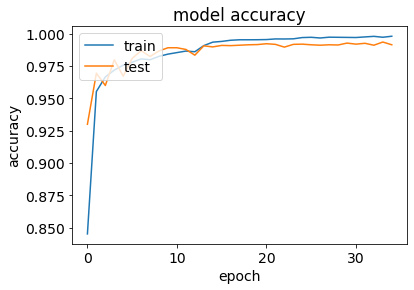

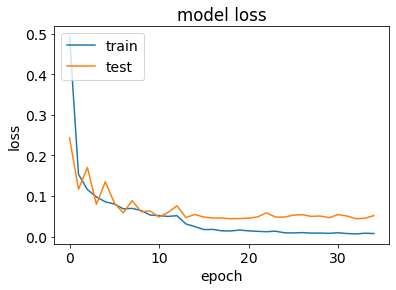

In [98]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

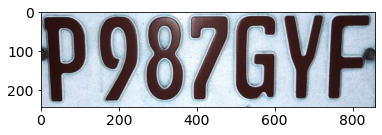

In [157]:
img = cv2.imread('p2.jfif')
plt.imshow(img)

In [136]:
img.shape

(243, 859, 3)

(243, 859)

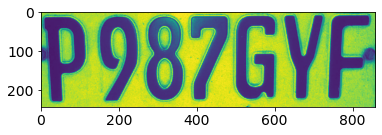

In [138]:
img = cv2.imread('p2.jfif',0)
plt.imshow(img)
img.shape

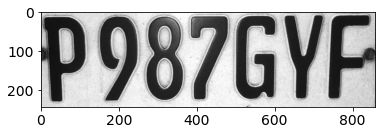

In [139]:
plt.imshow(img,cmap = 'gray')

In [151]:
image=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [154]:
tf.test.gpu_device_name()

''

In [155]:
device_lib.list_local_devices()

NameError: name 'device_lib' is not defined